# Natural Language Processing (NLP) - Classificação de Sentimentos

In [1]:
# Apaga todas as variáveis
%reset

In [1]:
# Pacotes necessários (tirar o comentário para instalar)
# !pip install pandas
# !pip install matplotlib
# !pip install sklearn
# !pip install nltk
# !pip install lime
# !pip install seaborn
# !pip install matplotlib_venn

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Bibliotecas

In [5]:
# Bibliotecas básicas
import os
import sys
import string
from unicodedata import normalize
import time
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Processamento dos Dados
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD

**********

## Preparando o ambiente

In [7]:
# Define a pasta onde está o arquivo my_fuctions.py
sys.path.insert(0, './lib')
# exibir a plotagem diretamente abaixo da célula de código que o produziu
%matplotlib inline
# define o estilo a ser aplicado nas plotagens
sns.set_style('darkgrid')

In [8]:
# O puknt dataset é necessários para realizar a tarefa de tokenização
nltk.download('punkt') 
# Instala a lista de stopwords
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/rflmorais/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rflmorais/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Funções Próprias

Funções criadas para serem utilizadas nas tarefas de processamento, análise exploratória, criação e avaliação dos modelos.

In [9]:
# Importa as funções do arquivo my_functions.py
import my_ml_functions as ml_tools

Módulo importado com sucesso em 19-01-2021 às 10:40:30


***************

## 2. Coleta de Dados

In [10]:
# Pasta do projeto
folder_path = '../13_TCC/'
# Lista de datasets do projeto
print(f'Arquivos utilizados no projeto: \n{os.listdir(folder_path + "assets/")}\n')

Arquivos utilizados no projeto: 
['.DS_Store', 'fig', 'lgr_model.pkl', 'corpus_2021-01-07.csv', 'b2w-reviews01.csv', 'olist_order_reviews_dataset.csv']



### Olist Review Dataset

Este é um conjunto de dados público de comércio eletrônico brasileiro de pedidos feitos na Olist Store. O conjunto de dados contém informações de 100 mil pedidos de 2016 a 2018 feitos em diversos mercados no Brasil.

Estes são dados comerciais reais, foram anonimizados e as referências às empresas e parceiros no texto da avaliação foram substituídas pelos nomes das grandes famílias de Game of Thrones.

Neste trabalho será usado os dados do arquivo `olist_order_reviews_dataset.csv`

Este conjunto de dados inclui dados sobre as avaliações feitas pelos clientes.

Depois que um cliente compra o produto na Olist Store, um vendedor é notificado para atender a esse pedido. Assim que o cliente recebe o produto, ou a data estimada de entrega está vencida, o cliente recebe por e-mail uma pesquisa de satisfação onde pode dar uma nota sobre a experiência de compra (numa escala de 1 a 5) e escrever alguns comentários.

In [11]:
# Carrega os dados brutos do dataset Olist
olist_order_reviews = pd.read_csv(folder_path + 'assets/olist_order_reviews_dataset.csv')

#### Conhecendo os dados do dataset Olist


In [8]:
olist_order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [9]:
olist_colunms = list(olist_order_reviews.columns)
olist_colunms_description = ['Identificador de avaliação único', 'Identificador de pedido único', 'Nota de 1 a 5 dada pelo cliente em pesquisa de satisfação.', 'Título do comentário a partir da avaliação deixada pelo cliente, em português.', 'Mensagem de comentário da crítica deixada pelo cliente, em português.', 'Mostra a data em que a pesquisa de satisfação foi enviada ao cliente.', 'Mostra o timestamp da resposta da pesquisa de satisfação.']
olist_type = ['texto', 'texto', 'int64', 'texto', 'texto', 'data', 'data']
olist_metadata = pd.DataFrame({})

In [10]:
olist_metadata['Colunas'] = olist_colunms
olist_metadata['Descrição'] = olist_colunms_description
olist_metadata['Tipo'] = olist_type
with pd.option_context("max_colwidth", None): # impede de trucar o texto em linhas muito longas
    display(olist_metadata)

,Colunas,Descrição,Tipo
0,review_id,Identificador de avaliação único,texto
1,order_id,Identificador de pedido único,texto
2,review_score,Nota de 1 a 5 dada pelo cliente em pesquisa de satisfação.,int64
3,review_comment_title,"Título do comentário a partir da avaliação deixada pelo cliente, em português.",texto
4,review_comment_message,"Mensagem de comentário da crítica deixada pelo cliente, em português.",texto
5,review_creation_date,Mostra a data em que a pesquisa de satisfação foi enviada ao cliente.,data
6,review_answer_timestamp,Mostra o timestamp da resposta da pesquisa de satisfação.,data


In [11]:
olist_order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [12]:
print(f'O Olist Review Dataset possui {olist_order_reviews.shape[0]:,} linhas e {olist_order_reviews.shape[1]} colunas.')

O Olist Review Dataset possui 100,000 linhas e 7 colunas.


### B2W-Reviews01 Dataset

B2W-Reviews01 é um corpus aberto de análises de produtos. Ele contém mais de 130 mil avaliações de clientes de comércio eletrônico, coletadas no site da Americanas.com entre janeiro e maio de 2018.

Depois que um produto é entregue com sucesso ao cliente, a empresa envia um e-mail com um link para o formulário de avaliação do produto.  Este formulário também pode ser acessado na página do produto, para que qualquer cliente possa escrever um comentário a qualquer momento, sem a necessidade de ter comprado o produto na Americanas.com. O formulário de avaliação consiste em uma avaliação geral do produto variando de 1 (ruim) a 5 (excelente). Todos os campos são obrigatórios e o texto da revisão deve ter pelo menos 50 caracteres.

In [13]:
# Carrega os dados brutos do dataset B2W
b2w_order_reviews = pd.read_csv(folder_path + 'assets/B2W-Reviews01.csv', sep=';')

#### Conhecendo os dados do dataset B2W-Reviews01

In [14]:
b2w_order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132373 entries, 0 to 132372
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   submission_date        132373 non-null  object 
 1   reviewer_id            132373 non-null  object 
 2   product_id             132373 non-null  object 
 3   product_name           132289 non-null  object 
 4   product_brand          40982 non-null   object 
 5   site_category_lv1      132367 non-null  object 
 6   site_category_lv2      128360 non-null  object 
 7   review_title           132373 non-null  object 
 8   overall_rating         132373 non-null  int64  
 9   recommend_to_a_friend  132355 non-null  object 
 10  review_text            132373 non-null  object 
 11  reviewer_birth_year    126389 non-null  float64
 12  reviewer_gender        128237 non-null  object 
 13  reviewer_state         128382 non-null  object 
dtypes: float64(1), int64(1), object(12)


In [15]:
b2w_columns = list(b2w_order_reviews.columns)
b2w_columns_description = ['data de envio da avaliação (formato AAAA-MM-DD hh: mm: ss)', 'id único do avaliador', 'id único do produto','nome do produto', 'marca do produto', 'categoria de produto de primeiro nível', 'categoria de produto de segundo nível', 'título da avaliação','classificação geral do cliente, de 1 a 5', '(“Sim” / “Não”)',  'texto principal', 'ano de nascimento', 'F/M', 'Estado Brasileiro' ]
b2w_type = ['data/hora', 'texto', 'int64', 'texto', 'texto', 'texto', 'texto', 'int64', 'categórico', 'texto', 'texto', 'int64', 'categórico', 'texto' ]
b2w_metadata = pd.DataFrame({})
b2w_metadata['Colunas'] = b2w_columns
b2w_metadata['Descrição'] = b2w_columns_description
b2w_metadata['Tipo'] = b2w_type

In [16]:
with pd.option_context("max_colwidth", None): # impede de trucar o texto em linhas muito longas
    display(b2w_metadata)

,Colunas,Descrição,Tipo
0,submission_date,data de envio da avaliação (formato AAAA-MM-DD hh: mm: ss),data/hora
1,reviewer_id,id único do avaliador,texto
2,product_id,id único do produto,int64
3,product_name,nome do produto,texto
4,product_brand,marca do produto,texto
5,site_category_lv1,categoria de produto de primeiro nível,texto
6,site_category_lv2,categoria de produto de segundo nível,texto
7,review_title,título da avaliação,int64
8,overall_rating,"classificação geral do cliente, de 1 a 5",categórico
9,recommend_to_a_friend,(“Sim” / “Não”),texto


***********

## Pré-processamento dos Dados

### Olist Review Dataset

In [17]:
#verificando a presença de avaliação em duplicidade utlizando a coluna review_id
print(f''''
Total de avaliações: {olist_order_reviews.shape[0]}
Total de avaliações únicas: {olist_order_reviews['review_id'].nunique()}
Total de avaliações duplicadas: {olist_order_reviews.shape[0] - olist_order_reviews['review_id'].nunique()}
'''
)

'
Total de avaliações: 100000
Total de avaliações únicas: 99173
Total de avaliações duplicadas: 827



In [18]:
# Eliminando as linhas com avaliação em duplicidade
olist_order_reviews.drop_duplicates(subset = 'review_id', inplace=True)
print(f'O novo total de avaliações é: {olist_order_reviews.shape[0]}')

O novo total de avaliações é: 99173


O dataset possui 7 colunas, porém, para o objetivo proposto, só interessa as colunas `review_score`, `review_comment_title`  e `review_comment_message`.

In [19]:
# Criando um novo DataFrame somente com a colunas de interesse
df_olist = olist_order_reviews.loc[:,['review_score', 'review_comment_title','review_comment_message']]
# Renomeando as colunas para que possam ficar acessíveis mais facilmente
df_olist.columns = ['score', 'review_title', 'review_text']
df_olist.info()
display(df_olist.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99173 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   score         99173 non-null  int64 
 1   review_title  11665 non-null  object
 2   review_text   41431 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.0+ MB


,score,review_title,review_text
0,4,NaN,NaN
1,5,NaN,NaN
2,5,NaN,NaN
3,5,NaN,Recebi bem antes do prazo estipulado.
4,5,NaN,Parabéns lojas lannister adorei comprar pela I...


In [20]:
print(f'O DataFrame Olist agora possui {df_olist.shape[1]} colunas e {df_olist.shape[0]} registros únicos.')

O DataFrame Olist agora possui 3 colunas e 99173 registros únicos.


### B2W Dataset

O dataset possui B2W possui 7 colunas, porém, para o objetivo proposto, só interessa as colunas `overall_rating`, `review_title` e 	`review_text`. Ressalva-se que neste dataset não há um identificador único para as avaliações o que impossibilita a busca por registro duplicados.

In [21]:
# Cria um novo DataFrame somente com a colunas de interesse
df_b2w = b2w_order_reviews.loc[:,['overall_rating', 'review_title', 'review_text']]
# Renomeia as colunas com o mesmo label do dataframe da Olist
df_b2w.columns = ['score', 'review_title','review_text']
df_b2w.info()
display(df_b2w.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132373 entries, 0 to 132372
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   score         132373 non-null  int64 
 1   review_title  132373 non-null  object
 2   review_text   132373 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.0+ MB


,score,review_title,review_text
0,4,Bom,Estou contente com a compra entrega rápida o ú...
1,4,"Preço imbatível, ótima qualidade","Por apenas R$1994.20,eu consegui comprar esse ..."
2,4,ATENDE TODAS AS EXPECTATIVA.,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3,4,presente mais que desejado,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4,5,"Sem duvidas, excelente","A entrega foi no prazo, as americanas estão de..."


In [22]:
print(f'O DataFrame B2W agora possui {df_b2w.shape[1]} colunas e {df_b2w.shape[0]:,} linhas.')

O DataFrame B2W agora possui 3 colunas e 132,373 linhas.


### Jutandos os datasest da Olist e da B2W-Digital em um único DataFrame 

In [23]:
df_reviews = pd.concat([df_olist, df_b2w])

In [24]:
print(f'Da junção do Dataset Olist e Dataset B2W surgiu o DataFrame df_reviews com {df_reviews.shape[1]} colunas e {df_reviews.shape[0]:,} registros.')

Da junção do Dataset Olist e Dataset B2W surgiu o DataFrame df_reviews com 3 colunas e 231,546 registros.


A junção dos 2 dataset objetiva obter um corpus com mais linhas para assim buscar uma melhor peformance do procedimentos de classificação. 
Conforme poderá ser observado nas próximas etapas, haverá uma redução de registros em razão do tratamento do texto. 

In [25]:
df_reviews.head()

,score,review_title,review_text
0,4,NaN,NaN
1,5,NaN,NaN
2,5,NaN,NaN
3,5,NaN,Recebi bem antes do prazo estipulado.
4,5,NaN,Parabéns lojas lannister adorei comprar pela I...


**********

## Processamento / Tratamento dos Dados

### Feature Engineering

Criando uma nova coluna (review) a partir da combinação das colunas review_title e review_text.

In [26]:
# Cria uma nova feature a partir da junção das colunas titulo e avaliação
df_reviews['review'] = df_reviews[['review_title', 'review_text']].apply(lambda x: " ".join(str(y) for y in x if str(y) != 'nan'), axis = 1)
# vizualizando as 5 últimas linhas
df_reviews.tail()

,score,review_title,review_text,review
132368,5,Ótimo produto!,"Vale muito, estou usando no controle do Xbox e...","Ótimo produto! Vale muito, estou usando no con..."
132369,5,Sensacional,"Prático e barato, super indico o produto para ...","Sensacional Prático e barato, super indico o p..."
132370,4,Ótimo produto,Chegou antes do prazo previsto e corresponde a...,Ótimo produto Chegou antes do prazo previsto e...
132371,1,O produto não é bom.,"Material fraco, poderia ser melhor. Ficou deve...","O produto não é bom. Material fraco, poderia s..."
132372,1,Produto não entregue,"Comprei esse produto, quando chegou estava com...","Produto não entregue Comprei esse produto, qua..."


In [27]:
# Eliminando as colunas review_title e review_text
df_reviews.drop(['review_title', 'review_text'], axis=1, inplace=True)
# Visualizando as 5 últimas colunas
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231546 entries, 0 to 132372
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   score   231546 non-null  int64 
 1   review  231546 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.3+ MB


O procedimento de concatenar realizado na etapa anterior, gerou registros com strings vazios nas linhas onde as colunas review_titlle e review_text possuiam valores nulos (NaN). Desta forma, o Pandas não reconhece esses registros como valores nulos, apesar de estarem vazios. 

O procedimento a seguir, imputará para estas linhas vazias o valor nulo (NaN).

In [28]:
# Imputando o valor NaN para as linhas vazias
df_reviews['review'].replace('', np.nan, inplace=True)
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231546 entries, 0 to 132372
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   score   231546 non-null  int64 
 1   review  175525 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.3+ MB


### Valores Nulos

In [29]:
# Computa a quantidade de dados nulos
score_null = df_reviews['score'].isnull().sum()
review_null = df_reviews['review'].isnull().sum()
print(f'O dataset possui {score_null} registros sem atribuição de nota, e {review_null:,} registros sem atribuição de comentário.')

O dataset possui 0 registros sem atribuição de nota, e 56,021 registros sem atribuição de comentário.


Por ser tratar de texto, não é possível aplicar nenhuma medida estatístia para preencher esses campos nulos, portanto, serão eliminados.

In [30]:
# Elimina as linhas que não possuem comentários
df_reviews = df_reviews.dropna(axis=0)
print(f'O dataset agora possui {df_reviews.shape[0]:,} linhas e {df_reviews.shape[1]} colunas.')

O dataset agora possui 175,525 linhas e 2 colunas.


Sendo assim, há mais de 175 mil comentários que podem ser usados para treinar o modelo para classificar a polaridade dos comentários (posito ou negativo).
Para realizar este trabalho será necessário realizar uma preparação do texto para trasnformar o texto de comentário em um vetor que possa ser interpretado por um modelo de Machine Learning.

### Distribuição das notas de avaliação

A avaliação consiste em  uma nota variando de 1 (ruim) a 5 (excelente), um título e um texto da avaliação. Neste momento está se fazendo uma breve exploração do dados só para compreender melhor como as notas estão distribuidas.

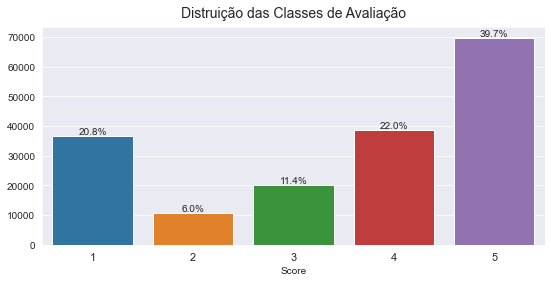

In [31]:
ml_tools.plot_target_count(df_reviews, 'score')

É posssível percerber que a principal nota de avaliação no dataset é uma taxa de escala de 5 pontos e que a mesma está desbalanceada (não há uma harmonia de distribuição entre as classes), mas isso será assunto para mais tarde.

Seguindo muitos outros trabalhos que analisam resenhas de corpora também classificadas em uma escala de 5 pontos, argumentam que "é melhor considerar apenas as resenhas classificadas de 0 a 2 como negativas e aquelas classificadas como 4 e 5 como positivas.

As avaliações classificadas com nota 3 podem ser positivas, negativas ou neutras dentro do mesmo universo (ambíguas). Portanto, para a classificação de polaridade, as avaliações classficadas com nota 3, serão descartadas.

#### Polarizando as notas de avaliação em Negativo (0) e Positivo (1)

O objetivo do presente trabalho é classifcar uma avaliação como sendo positiva ou negativa. Sendo assim, as notas atribuidas serão distribuidas em dois valores, positivo ou negativo, contruindo assim uma divisão binária das notas.

In [32]:
# Quantidade de reviews por classe
df_reviews.groupby('score').count()

,review
score,
1,36522
2,10609
3,20036
4,38641
5,69717


In [33]:
# Cria um novo dataframe com as avaliações com notas 4 ou 5
pos = df_reviews[(df_reviews['score'] == 4) | (df_reviews['score'] == 5)]
# Quantidade de review por classe
pos.groupby('score').count()

,review
score,
4,38641
5,69717


In [34]:
# Cria um novo dataframe com as avaliações com notas 1 ou 2
neg = df_reviews[(df_reviews['score'] == 1) | (df_reviews['score'] == 2)]
# Quantidade de review por classe
neg.groupby('score').count()

,review
score,
1,36522
2,10609


In [35]:
# Atribuí 1 (positiva) e 0 (negativa)
pos['score'] = 1
neg['score'] = 0

In [36]:
# Concatena os dataframes pos e neg e um uníco dataframe (data)
data = pd.concat([pos, neg]).reset_index(drop=True)
print(f'O novo DataFrame possui {data.shape[0]:,} linhas ditribuido entre avaliações positivas ou negativas')

O novo DataFrame possui 155,489 linhas ditribuido entre avaliações positivas ou negativas


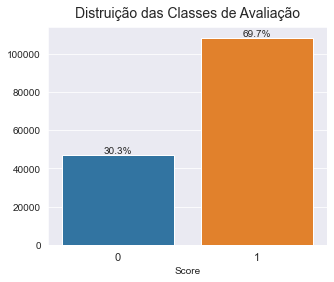

In [37]:
ml_tools.plot_target_count(data, 'score', (5,4))

É possível notar um possível desbalancemaento do dataset. Quase 70% das avaliações são classificadas como positivas. Nesta situação pode ocorrer o enviesamento do modelo, ou seja, ele pode tender a classificar novos dados como sendo da classe que possui mais exemplos.

Esse assunto será abordado mais adiante.

### Limpando os dados

Um conjunmto de dados limpo permitirá que um modelo aprenda apenas recursos signifivamente relevantes sem ruídos. Ruídos são características do texto que não são significativos para caracterizar o que se pretende avaliar. 

No dataset analisado o nome de entidades usada para compor determinadas palavras em nada caracteriza o texto propriamente dito. Outras caracteríisticas que precisam ser consideradas na limpeza dos dados são:

* Converter termos para minúsculos, homogeneizando os dados (OLÁ – olá);
* Remover caracteteres irrelevantes (tags HTML, etc);
* Combinar palavras escritas incorretamente para uma única representação (legaaalll – legal);
* Quebrar o texto em termos (bag-of-words / tokenização).
* Remover as palvras stopwords (artigos, preposições e outras) já que não dão muito sentido às frases
* Eliminar os sinais de acentos
* Aplicar a técnica Stemming (derivação). É uma heurística baseada em regras, para eliminar sufixos comuns (gostar, gostei, gostaria -> gost).

#### Removendo padrões que não agregam valor (Regular Expressions)

Considerando que a fonte do comentários no dataset analisado é a internet, provavelmente haverá algumas tags HTML, linhas de quebra, caracteres especiais, link para site, datas e outros conteúdos que podem fazer parte do conjunto de dados, e que não agregam valor para a tarefa de classficação. 

Função: `normalize_text(df, text_field)`

In [38]:
antes = data['review'].head().copy()

In [39]:
data = ml_tools.normalize_text(data,'review')

In [40]:
# ml_tools.make_latex(antes, 'antes_regex', index=True)
# ml_tools.make_latex(data['review'].head(), 'depois_regex')

In [41]:
print(
    f'''
    Exemplos antes de aplicar o RegEx:\n
    {antes}

    ============================================================

    Após aplicar o Regex:\n
    {data['review'].head().values}
'''
)


    Exemplos antes de aplicar o RegEx:

    0                Recebi bem antes do prazo estipulado.
1    Parabéns lojas lannister adorei comprar pela I...
2    recomendo aparelho eficiente. no site a marca ...
3      Mas um pouco ,travando...pelo valor ta Boa.\r\n
4    Super recomendo Vendedor confiável, produto ok...
Name: review, dtype: object


    Após aplicar o Regex:

    ['recebi bem antes do prazo estipulado.'
 'parabens lojas lannister adorei comprar pela internet seguro e pratico parabens a todos feliz pascoa'
 'recomendo aparelho eficiente. no site a marca do aparelho esta impresso como desinfector e ao chegar esta com outro nome.atualizar com a marca correta uma vez que e o mesmo aparelho'
 'mas um pouco ,travando.pelo valor ta boa.  '
 'super recomendo vendedor confiavel, produto ok e entrega antes do prazo.']



#### Remove pontuação

Função: `remove_punctuations(text)`

In [42]:
# Remove a pontuação e salva o resultado na mesma coluna (review)
data['review'] = data['review'].apply(ml_tools.remove_punctuations)

In [43]:
data.head()

,score,review
0,1,recebi bem antes do prazo estipulado
1,1,parabens lojas lannister adorei comprar pela i...
2,1,recomendo aparelho eficiente no site a marca ...
3,1,mas um pouco travando pelo valor ta boa
4,1,super recomendo vendedor confiavel produto ok...


#### Remove as linhas onde há somente 2 ou menos caracteres. 

In [44]:
# Exemplo de 10 linhas com 2 ou menso caracteres 
data[data['review'].map(len) <= 2].head(10)

,score,review
43,1,ok
80,1,a
122,1,
164,1,
168,1,
272,1,
382,1,
385,1,
399,1,a
733,1,ok


In [45]:
# Remove as linhas com 2 ou menos caracteres
data.drop(data[data['review'].map(len) <= 2].index, inplace=True)

### Transformando os dados

Após o tratamente dos dados com RegEx, o conjunto de dados de texto está sem alguns padrões que não serviam para agregar valor. Em outras palavras, o dataset possui um texto parcialmente limpo.

Portanto, agora, será aplicadas transformações de texto avançadas, como remoção de palavras irrelevantes a partir de uma lista (stopwords) e técnicas de normalização do texto, como a lematização (lemmatization).

Antes de aplicar estas transformações avançadas é preciso quebrar o texto em palavras, método conhecido como Tokenization.

#### Tokenization

Tokenização é o processo de “quebrar ” o texto em unidades menores, sendo os tokens as unidades mínimas em que o texto pode ser fragmentado. Por exemplo fragmentando a frase “Este produo é muito bom.” em palavras teríamos 6 tokens \[“Este”, "produto", ”é”, ”muito”,”bom”, "."] para posterior vetorização.

É uma das primeiras etapas em qualquer pipeline de Natural Language Processing. E é necessária
pois ao ter uma lista de palavras, pode-ser usar ferramentas e métodos estatísticos para obter mais informações sobre o texto. Por exemplo, pode-se usar a contagem de palavras e a frequência de palavras para descobrir as mais importantes em uma frase ou documento.


Existem várias técnicas de tokenização em dados de texto. Neste trabalho será aplicado o modulo word_tokenize da biblioteca Natural Language Toolkit (NLTK).

Função: `tokenizer(row)`

In [46]:
# Cria uma nova coluna (tokens) com o bag-of-words
data['tokens'] = data.apply(ml_tools.tokenizer, axis=1)

In [47]:
data.head()

,score,review,tokens
0,1,recebi bem antes do prazo estipulado,"[recebi, bem, antes, do, prazo, estipulado]"
1,1,parabens lojas lannister adorei comprar pela i...,"[parabens, lojas, lannister, adorei, comprar, ..."
2,1,recomendo aparelho eficiente no site a marca ...,"[recomendo, aparelho, eficiente, no, site, a, ..."
3,1,mas um pouco travando pelo valor ta boa,"[mas, um, pouco, travando, pelo, valor, ta, boa]"
4,1,super recomendo vendedor confiavel produto ok...,"[super, recomendo, vendedor, confiavel, produt..."


In [48]:
# ml_tools.make_latex(data[['review', 'tokens']].head(), 'df_tokens.tex', index=True, max_colwidth=False)

#### Stopwords

As stopwords são palavras que não atribuem significado ao texto, e portanto podem ser removidas. Isso reduz a quanitdade de ruído bem como reduz a dimensão.

Para este trabalho foi utilizada lista de stopwords da biblioteca NLTK. Foi ainda criada a lista custom_stops, por entender que estas palavras estariam presente no corpus com uma certa frequência e não acrescentam valor para a classificação em positivo e negativos. O nome das casas de Game of Thrones estão presente porque na documentaçao do dataset da Olist é informado que o nome real das lojas foram subistituidos por estes.

A palavra "não" e "muito" foram excluídas da lista de stopwords por entender que agregam valor na classificação. Sendo que uma representa negação e a outra intensidade. Mais adiante este tema será melhor explorado.

Porém, antes de aplicar a remoção destes termos, é interessante conhcer quais são as palavras mais comuns no dataset.

#### Termos mais frequentes 

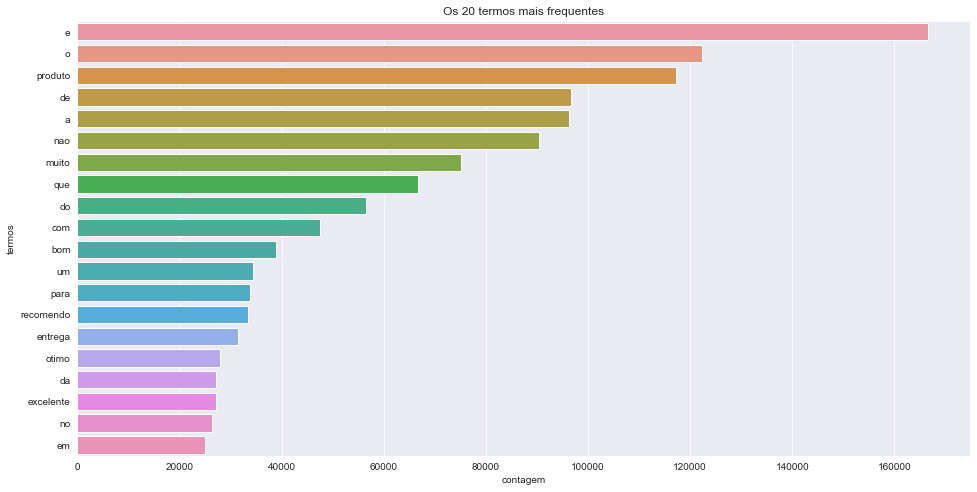

In [49]:
# Plota os 30 temos mais frequentes no dataset
ml_tools.freq_words_df_or_plot(data['review'], terms=20, savefig=True)

#### Remoção das Stopwords

É possível perceber que dentre as palavras mais comuns do dataset, estão termos que não agregam nenhum valor, como os artigos e preposições.
Estes termos, estão presentes na lista de Stopwords da biblioteca NLTK, por serem os mais comuns, mas além deste, é possivel perceber a palavra produto, como o terceiro tema mais frequente, e este também não agrega valor.
Tendo em vista o domínio analisado, foi crida a lista de Stopwords customizada.

In [50]:
# Cria uma nova coluna no datataset (imporant_tokens) com os termos que não esta na lista de stopwords
data['important_tokens'] = data.apply(ml_tools.remove_stops, axis=1)

In [51]:
data.head()

,score,review,tokens,important_tokens
0,1,recebi bem antes do prazo estipulado,"[recebi, bem, antes, do, prazo, estipulado]","[recebi, bem, antes, prazo, estipulado]"
1,1,parabens lojas lannister adorei comprar pela i...,"[parabens, lojas, lannister, adorei, comprar, ...","[parabens, adorei, comprar, internet, seguro, ..."
2,1,recomendo aparelho eficiente no site a marca ...,"[recomendo, aparelho, eficiente, no, site, a, ...","[recomendo, aparelho, eficiente, site, marca, ..."
3,1,mas um pouco travando pelo valor ta boa,"[mas, um, pouco, travando, pelo, valor, ta, boa]","[pouco, travando, valor, ta, boa]"
4,1,super recomendo vendedor confiavel produto ok...,"[super, recomendo, vendedor, confiavel, produt...","[super, recomendo, vendedor, confiavel, ok, en..."


### Reunir os tokens em uma string única

In [52]:
# Cria uma nova coluna com os tokens reunidos em uma string única
data = ml_tools.rejoin_words(data, 'processed_review', 'important_tokens')

In [53]:
data.head()

,score,review,tokens,important_tokens,processed_review
0,1,recebi bem antes do prazo estipulado,"[recebi, bem, antes, do, prazo, estipulado]","[recebi, bem, antes, prazo, estipulado]",recebi bem antes prazo estipulado
1,1,parabens lojas lannister adorei comprar pela i...,"[parabens, lojas, lannister, adorei, comprar, ...","[parabens, adorei, comprar, internet, seguro, ...",parabens adorei comprar internet seguro pratic...
2,1,recomendo aparelho eficiente no site a marca ...,"[recomendo, aparelho, eficiente, no, site, a, ...","[recomendo, aparelho, eficiente, site, marca, ...",recomendo aparelho eficiente site marca aparel...
3,1,mas um pouco travando pelo valor ta boa,"[mas, um, pouco, travando, pelo, valor, ta, boa]","[pouco, travando, valor, ta, boa]",pouco travando valor ta boa
4,1,super recomendo vendedor confiavel produto ok...,"[super, recomendo, vendedor, confiavel, produt...","[super, recomendo, vendedor, confiavel, ok, en...",super recomendo vendedor confiavel ok entrega ...


In [54]:
# elimina colunas que não são mais necessárias
data.drop(['review', 'tokens', 'important_tokens'], axis=1, inplace=True)

In [55]:
data.head()

,score,processed_review
0,1,recebi bem antes prazo estipulado
1,1,parabens adorei comprar internet seguro pratic...
2,1,recomendo aparelho eficiente site marca aparel...
3,1,pouco travando valor ta boa
4,1,super recomendo vendedor confiavel ok entrega ...


### Remoção de linhas com 2 ou menos caracteres

Após todas as etapas de processamento e normalização, buscará linha onde há 2 ou menos caracters. Estas linhas serão eliminadas, por entenderem que não são capazes de agregar valor.

In [56]:
# Exemplo de 5 linhas com 2 ou menos caracteres 
data[data['processed_review'].map(len) <= 2].head()

,score,processed_review
104,1,
233,1,n
969,1,ok
979,1,
2809,1,


In [57]:
# Remove as linhas com 2 ou menos caractere
data.drop(data[data['processed_review'].map(len) <= 2].index, inplace=True)
# Coloca as colunas em uma ordem mais padronizada (label por último)
data = data[['processed_review', 'score']]

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155026 entries, 0 to 155488
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   processed_review  155026 non-null  object
 1   score             155026 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.5+ MB


In [59]:
# ml_tools.make_latex(data.head(), 'df_processed.tex')

************

## Salvando o Dataset Processado no  disco

Etapa opcional. Salva o arquivo no disco com data do dia do salvamento para diferenciar as versões.
A tarefa de processamento e normalização de dados no formato de texto requer muitos recursos computacionais, portanto é recomendável salvar no disco o dataset já processado.

In [60]:
data.to_csv(f'assets/corpus_{dt.date.today()}.csv', index=False)

***********

In [61]:
ml_tools.success_message(1)

 

    Todos os trechos de código deste Jupyter Notebook foram executados com sucesso.
    O corpus limpo e processado foi salvo na pasta do projeto com o nome corpus_2021-01-16.csv.
    Agora prossiga no Jupyter Notebook 02_Eploratory_Analysis.ipynb para a Análise Exploratória dos Dados.
    
    
